# Script for finding enrichment of marker combinations

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import os, sys
import anndata as ad

import itertools
import random
import string

sys.path.append(os.path.join('..'))
from IMCprocess.img_anndata.img_anndata import Img_anndata
import IMCprocess.spatial_analysis.spatial_analysis as sa
import IMCprocess.spatial_analysis.combi_enrich as ce

## Use function from combi enrich

In [2]:

# Create a random cell1 and cell2 for testing
df1 = ce.rand_marker_XY()
df2 = ce.rand_marker_XY()
df2.index = list(range(1001, 2001))
cell1_adata = Img_anndata(dfs=[df1], img_ids=['R1']).adata
cell2_adata = Img_anndata(dfs=[df2], img_ids=['R1']).adata

In [ ]:
# 2. label cell1 with zzcell1 and cell2 with combination markers + and -
#  and merge two cell types and calculate zscore of neighborhood enrichment
zscore_n2 = ce.zscore_combinations(cell1_adata, cell2_adata, n=2)


## Create random anndata for Two cell types
* Create anndata cell type 1 to pair with cell type 2 for enrichment analysis
* Create anndata of cell type 2 with combination of markers

In [3]:
def rand_marker_XY(ncol = 9, nrow=1000):
    columns_list=[string.ascii_uppercase[i] for i in range(ncol)]
    df = pd.DataFrame(np.random.rand(nrow, ncol), columns=columns_list)
    df['X_position'] = [random.uniform(0, 256) for _ in range(nrow)]
    df['Y_position'] = [random.uniform(0, 256) for _ in range(nrow)]
    return(df)

def col_combinations(df, n=2):
    '''
    Return all combinations of columns in a dataframe
    '''
    combinations = list(itertools.combinations(df.columns, n))
    combinations_as_lists = [list(c) for c in combinations]
    return(combinations_as_lists)

In [4]:
df1 = rand_marker_XY()
df2 = rand_marker_XY()
df2.index = list(range(1001, 2001))

In [5]:
df2.head()

,A,B,C,D,E,F,G,H,I,X_position,Y_position
1001,0.197511,0.763273,0.088366,0.754450,0.308201,0.964569,0.375335,0.982882,0.581088,91.608871,97.945401
1002,0.205615,0.032721,0.667574,0.105451,0.932768,0.253630,0.608073,0.731779,0.731461,167.419736,85.031024
1003,0.980062,0.976713,0.386569,0.425076,0.271137,0.814718,0.120907,0.648760,0.837415,36.690249,92.674356
1004,0.797435,0.650032,0.924948,0.337442,0.087943,0.695036,0.375378,0.817558,0.414541,96.167805,121.102073
1005,0.604231,0.239951,0.457226,0.235479,0.034287,0.596062,0.318978,0.665198,0.279427,237.602911,32.750087


In [6]:
Img_cell1 = Img_anndata(dfs=[df1], img_ids=['R1'])
Img_cell2 = Img_anndata(dfs=[df2], img_ids=['R1'])

## label cell with threshold for each marker for cell type2

In [7]:
def binary_dataframe(df, threshold=0.5):
    '''
    Return a DataFrame with binary columns based on a threshold
    '''
    binary_df = pd.DataFrame()
    for col in df.columns:
        binary_col = np.where(df[col] > threshold, 1, 0)
        binary_df[col] = binary_col
    return binary_df

In [8]:
binary_df = binary_dataframe(Img_cell2.adata.to_df())

In [9]:
binary_df.head()

,A,B,C,D,E,F,G,H,I
0,0,1,0,1,0,1,0,1,1
1,0,0,1,0,1,0,1,1,1
2,1,1,0,0,0,1,0,1,1
3,1,1,1,0,0,1,0,1,0
4,1,0,0,0,0,1,0,1,0


In [10]:
combi = col_combinations(binary_df, n=2)
combi[0:3]

[['A', 'B'], ['A', 'C'], ['A', 'D']]

In [11]:
def label_marker(df, marker_list):
    df = df[marker_list]
    for col in df.columns:
        df.loc[df[col] == 1, col] = col+'+'
        df.loc[df[col] == 0, col] = col+'-'
    df_label = pd.DataFrame(df.apply(lambda row: ''.join(row.astype(str)), axis=1), columns=['label'])
    #one_hotdf = pd.get_dummies(df_label['label'])
    df_label['label'] = df_label['label'].astype('category')
    return df_label

In [12]:
label_marker(binary_df, ['A', 'B']).head()

,label
0,A-B+
1,A-B-
2,A+B+
3,A+B+
4,A+B-


In [13]:
label_df = label_marker(binary_df, ['A', 'B'])

In [14]:
label_df.index = Img_cell2.adata.obs.index
Img_cell2.adata.obs = pd.concat([Img_cell2.adata.obs, label_df], axis=1)

In [15]:
Img_cell2.adata.obs.head()

,img_id,label
0_0,R1,A-B+
1_0,R1,A-B-
2_0,R1,A+B+
3_0,R1,A+B+
4_0,R1,A+B-


In [16]:
# label cell1 
Img_cell1.adata.obs['label'] = 'ZZcell1'
Img_cell1.adata.obs.head()

,img_id,label
0_0,R1,ZZcell1
1_0,R1,ZZcell1
2_0,R1,ZZcell1
3_0,R1,ZZcell1
4_0,R1,ZZcell1


In [17]:
merged_adata = ad.concat([Img_cell1.adata, Img_cell2.adata], axis=0)
merged_adata.obs['label'] = merged_adata.obs['label'].astype('category')

/Users/pattama/Desktop/UiB/venv_folder/IMCprocess_venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [18]:
merged_adata.obs

,img_id,label
0_0,R1,ZZcell1
1_0,R1,ZZcell1
2_0,R1,ZZcell1
3_0,R1,ZZcell1
4_0,R1,ZZcell1
...,...,...
995_0,R1,A+B-
996_0,R1,A+B+
997_0,R1,A+B+
998_0,R1,A-B+


In [19]:
sa.run_spatial_nhood(merged_adata, 'label', 15)

/Users/pattama/Desktop/UiB/venv_folder/IMCprocess_venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [00:05<00:00, 169.65/s]


<Figure size 200x100 with 0 Axes>

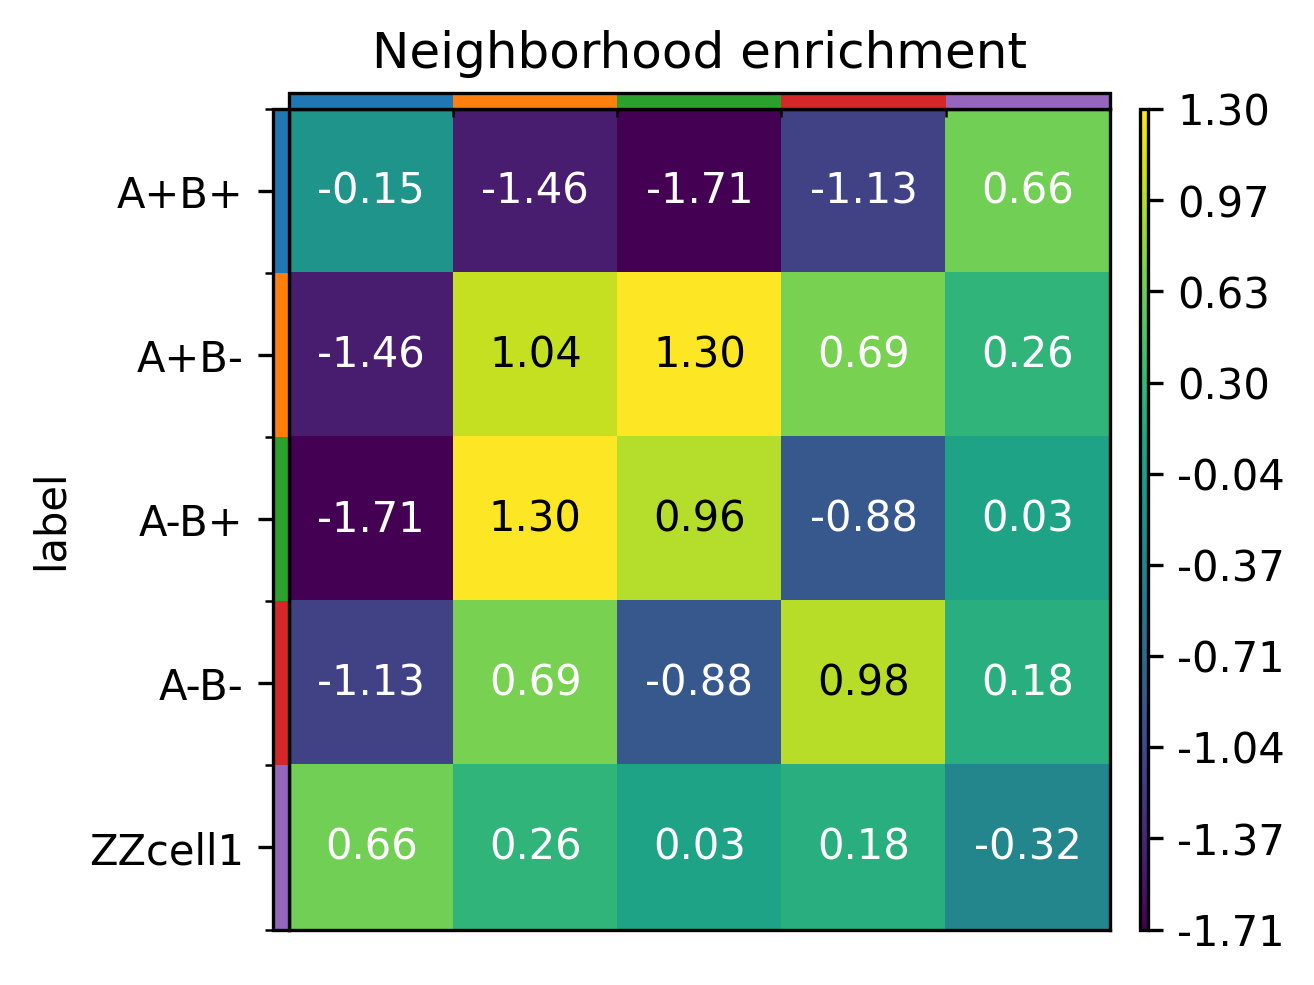

In [18]:
sa.plt_spatial_nhood(merged_adata, 'label', './output/','test', img_size=(2,1))

In [21]:
zscore = merged_adata.uns['label_nhood_enrichment']['zscore'][-1]
label_index = merged_adata.obs['label'].cat.categories

In [31]:
pd.DataFrame(zscore[:-1], index=label_index[:-1], columns=['ZZcell1']).T

,A+B+,A+B-,A-B+,A-B-
ZZcell1,0.657366,0.260711,0.032793,0.177848
